<h3>This Jupyter Notebook is an assembled notebook that includes all members' work for a clear and neat presentation.<br></h3>

<h3> Team Name: Henry Erzi</h3>
<h3>Work Allocation:<br></h3>
Raymond Lu (z5277884): Multinomial Naive Bayes Model<br>
Ziyang Liang: Decision Tree Classifier Model<br>
Yangqi Zhang(z5235062): Support Vector Classification Model<br>
Yunze Shi(z5244619): Logistic Regression Model<br>
Yinong Wang: Neural Network, Ensemble Model Design <br>
<br>
All: Text Report, Assembled Notebook


<h2> NOTE: Some cells in this notebook are copied and pasted from notebooks of members' work.

In [17]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.utils import shuffle
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from varname import varname
from collections import Counter
%matplotlib inline
#fix random seed
np.random.seed(1)

In [3]:
!jupyter nbextension enable vega --py --sys-prefix

# 1.Individual Model Construction

## 1.1Data Analysis

### 1.1.1Data Import

In [18]:
TRAINING_FILE = "../training.csv"
df_train = pd.read_csv(TRAINING_FILE)
print(df_train.isnull().sum())
df_train.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


From the result above, it could be seen that there are no *null* values in the training data set. And the topic feature is supposed to be predicted by article_words feature.

### 1.1.2Plot Data Distribution

In [5]:
data_x = df_train.article_words
data_y = df_train.topic

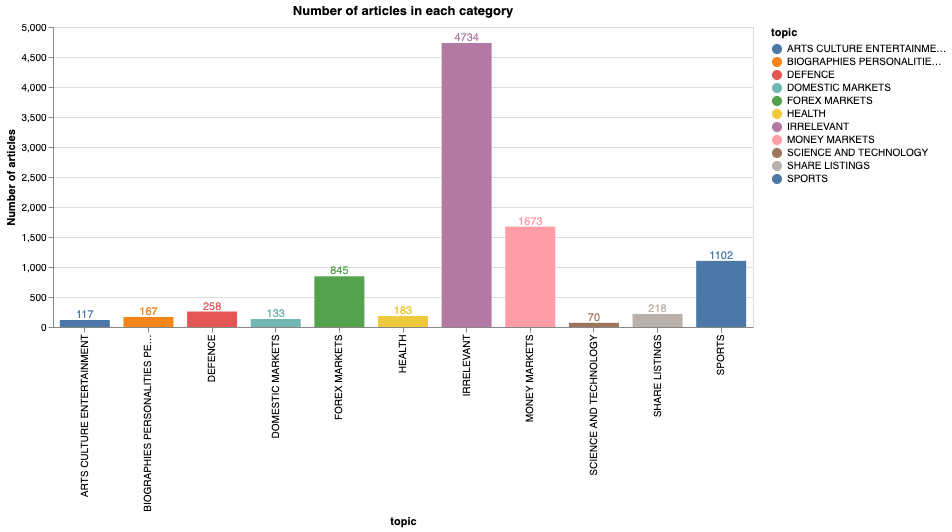

In [244]:
alt.data_transformers.disable_max_rows()
bars = alt.Chart(data_y.to_frame()).mark_bar(size=50).encode(
x=alt.X("topic"),
y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
tooltip=[alt.Tooltip('count()', title='Number of articles'), 'topic'],
color='topic'

)

text = bars.mark_text(
align='center',
baseline='bottom',
).encode(
text='count()'
)

(bars + text).properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)

From the plot above, it could be seen that the data distribution in the training data set is severely imbalanced, with **IRRELEVANT** topic occupies more than half amount.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 11 Text major ticklabel objects>)

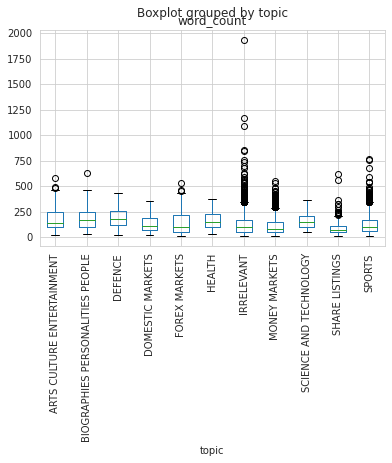

In [6]:
data = df_train
data['word_count'] = data.article_words.str.count(",")+1
data.boxplot(column ='word_count',by ='topic')
plt.xticks(rotation=90)

From the boxplot above, it could be seen that the variance of word count in **IRRELEVANT** topic is far higher than other topics. This means that the word count of **IRRELEVANT** topic varies in a substantial range.

### 1.1.3 Key Word Analysis for Each Topic

In [10]:
def word_count_function(word_list,topic_df):
    #return the only the words in word_list occur in the topic_df
    occurence_df = pd.DataFrame() #show their occurence in other topics 
    for words in word_list:
        occurence_dict = {}
        for name, group in topic_df :
            word_counter = Counter(" ".join(group["article_words"]).split(","))
            occurence = word_counter[words]
            avg_occurence = occurence / len(group)
            occurence_dict.update({name:avg_occurence})
        occur_series = pd.Series(occurence_dict) 
        occur_series.name = words
        occurence_df = occurence_df.append(occur_series, ignore_index = True)
    return(occurence_df.T)

In [14]:
#finding the most frequent words in training set by topics
topic_group = df_train.groupby('topic')
most_frequent_word_list = {}
word_list_10 = []
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(10)
    most_frequent_word_list.update({name:frequent_words})
    common_words = [i[0] for i in frequent_words]
    word_list_10 = word_list_10 + common_words
print(most_frequent_word_list)

{'ARTS CULTURE ENTERTAINMENT': [('year', 156), ('film', 153), ('million', 102), ('stat', 83), ('work', 81), ('offic', 80), ('show', 72), ('releas', 72), ('peopl', 70), ('music', 69)], 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249), ('presid', 198), ('yeltsin', 140), ('stat', 133), ('hospit', 124), ('offic', 122), ('lead', 121), ('minist', 119), ('told', 117), ('report', 113)], 'DEFENCE': [('nato', 511), ('stat', 410), ('milit', 406), ('forc', 381), ('defend', 357), ('minist', 345), ('offic', 317), ('russia', 299), ('presid', 238), ('plan', 235)], 'DOMESTIC MARKETS': [('import', 541), ('ton', 324), ('percent', 265), ('year', 262), ('oil', 191), ('trad', 189), ('chin', 186), ('export', 161), ('million', 151), ('produc', 140)], 'FOREX MARKETS': [('dollar', 3358), ('bank', 2178), ('rate', 1720), ('trad', 1671), ('market', 1662), ('percent', 1336), ('currenc', 1214), ('deal', 1208), ('mark', 1191), ('yen', 962)], 'HEALTH': [('year', 253), ('health', 245), ('stat', 241), ('diseas', 184),

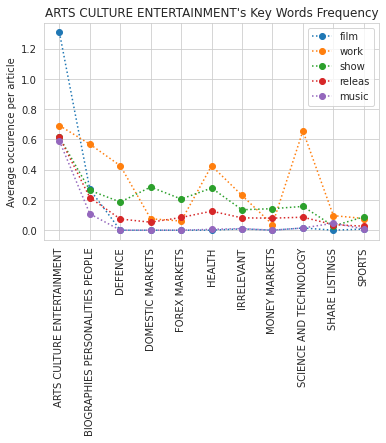

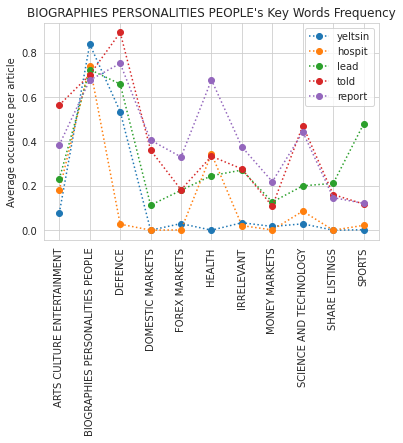

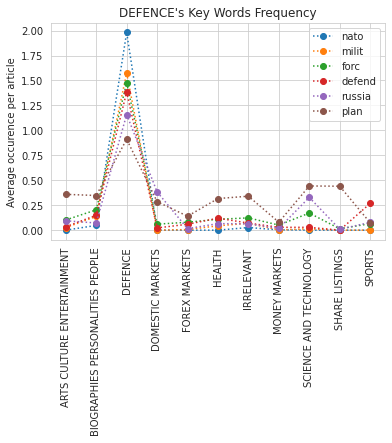

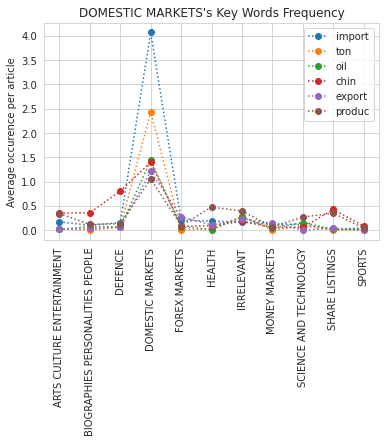

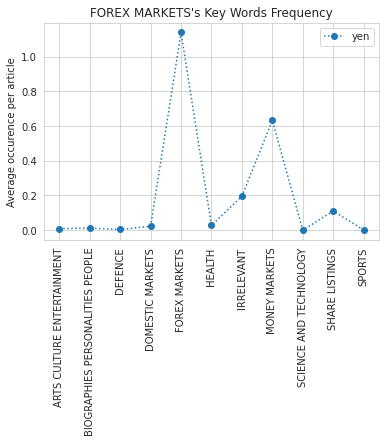

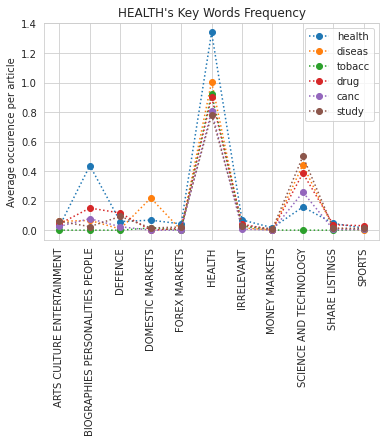

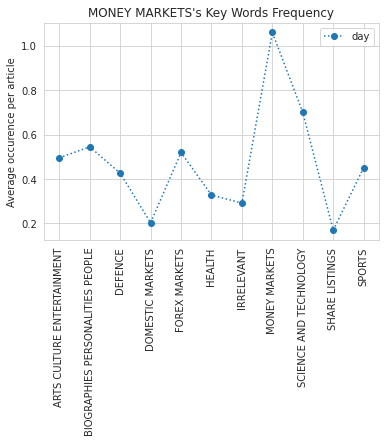

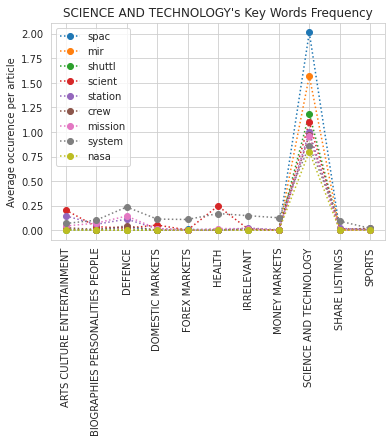

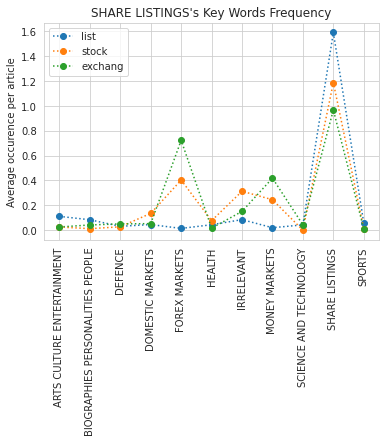

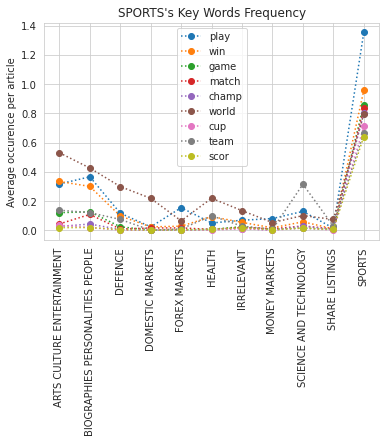

In [15]:
word_list_group = [ [i for i in word_list_10[j*10 :(j+1)*10 ] if word_list_10.count(i) == 1] for j in range(11) ]
#visaulize key word's performance
for i in range(11):
    if i == 6:
        continue #irrelevant do not have any words
    my_words = word_list_group[i]
    my_df = word_count_function(my_words,topic_group)
    
    my_df.columns = my_words
    my_df.plot(marker='o',style = ':')
    plt.xticks(np.arange(11), list(my_df.index),rotation=90)

    plt.title(list(my_df.index)[i] + '\'s Key Words Frequency')
    plt.ylabel('Average occurence per article')
    plt.show()

The plots above shows for each topic, how is the distribution of its own top key words among all topics other than **IRRELEVANT**. It could be seen that for **BIOGRAPHIES PERSONALITIES PEOPLE**, its top key words' occurences are not distinguishing from the ones of other topics. Worse still, its two key words, *told* and *report* have higer occurence in other topics. This indicates that, the prediction of **BIOGRAPHIES PERSONALITIES PEOPLE** would be in poor quality since this topic's features are not characteristical. <br><br>
In contrast, **DEFENCE**, **SHARE LISTING** and **SPORTS** are supposed to have ideal predictions on account that all their corresponding key words' occurences are obviously lower among other topics.

## 1.2 Solve Data Imbalance

In order to generate precise models, the data imbalance needs to be solved. Otherwise, the generated models are more likely to predict the results to be the majority topic in the training set. For the purpose of eliminating such bias, SMOTE (Synthetic Minority Oversampling Technique) is introduced to solve this problem.

*SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.*<br>
<div style="text-align:right">— Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.</div>

*Below is the fraction of code used later that using SMOTE to solve the imbalance problem.

In [ ]:
# ! DON'T RUN THIS CELL!!!!!!!!!!!!!
# Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])

*"train_x"* is a Numpy array that stores article words in the training data set, and *"en_train_y"* is encoded topics from the training set. After *train_x* getting vectorized, SMOTE augments the vectors of *train_vectors* and *en_train_y* to be *smo_x* and *smo_y*.

## 1.3 Key Word Extraction

We assume that extracting key words from the article_words feature in the testing data could improve the model's prediction, considering that some words in the test set could be low-frequent or even not showing up in the training set, which might bring noises to the model prediction.

In [19]:
from collections import Counter
import pandas as pd

def word_list_generator(data_group, n=10):
    my_word_list= []
    for name, group in data_group :
        frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(n)
        #most_frequent_word_list.update({name:frequent_words})
        common_words = [i[0] for i in frequent_words]
        my_word_list = my_word_list + common_words
    return(my_word_list)

def keep_key_words(x,word_list):
    key_list = [i for i in x.split(",") if i in  word_list]
    key_str = str(key_list).replace("'","").replace(" ","").replace("[","").replace("]","")
    return(key_str)

def df_keyword_generator(df_test, df_keywords):
    '''generate key words features in df_test based on keywords in df_keywords by topic '''
    topic_group = df_keywords.groupby('topic')
    words_in_df = df_test.article_words
    
    word_list10 = word_list_generator(topic_group, n=10)
    key_word_10 = words_in_df.apply(keep_key_words, args=(word_list10,))
    df_test['key_word_10'] = key_word_10
    
    word_list20 = word_list_generator(topic_group, n=20)
    key_word_20 = words_in_df.apply(keep_key_words, args=(word_list20,))
    df_test['key_word_20'] = key_word_20
    
    word_list50 = word_list_generator(topic_group, n=50)
    key_word_50 = words_in_df.apply(keep_key_words, args=(word_list50,))
    df_test['key_word_50'] = key_word_50
    
    word_list100 = word_list_generator(topic_group, n=100)
    key_word_100 = words_in_df.apply(keep_key_words, args=(word_list100,))
    df_test['key_word_100'] = key_word_100
    return(df_test)

df_train = df_keyword_generator(df_train,df_train)

In [20]:
df_train

,article_number,article_words,topic,key_word_10,key_word_20,key_word_50,key_word_100
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,"stock,rate,defend,bank,bank,bank,bank,bank,dol...","cent,cent,cent,stock,rate,end,won,won,won,won,...","open,cent,cent,cent,stock,rate,end,won,won,won...","open,cent,cent,cent,stock,rate,end,won,won,won..."
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,"day,day,day,bank,year,dollar,dollar,deal,deal,...","end,end,day,day,day,point,time,bank,year,dolla...","end,end,day,day,day,point,time,bank,early,year...","end,end,day,day,day,index,point,time,busi,bank..."
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,"world,world,stat,stat,stat,stat,year,releas,re...","world,world,stat,stat,stat,stat,govern,time,ye...","socc,socc,world,world,stat,stat,stat,stat,gove...","socc,socc,world,world,recent,law,stat,stat,sta..."
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,"play,bank,bank,mark,mark,percent,percent,perce...","cent,cent,end,play,unit,bank,bank,mark,mark,pe...","open,cent,cent,end,play,unit,made,bank,bank,tu...","open,cent,cent,end,play,unit,made,bank,bank,ra..."
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,day,"day,time,season,clos","minut,minut,minut,day,friday,friday,race,time,...","minut,minut,minut,day,friday,friday,race,time,..."
...,...,...,...,...,...,...,...
9495,9496,"cloud,provid,hope,centur,erupt,rule,recent,sou...",DEFENCE,"scient,year,year,lead,plan,plan,day,peopl,peop...","scient,year,year,month,lead,expect,expect,high...","south,scient,capit,intern,year,year,set,set,se...","centur,rule,recent,south,local,scient,capit,ju..."
9496,9497,"stock,stock,stock,declin,access,week,worry,blo...",IRRELEVANT,"stock,stock,stock,play,year,year,dollar,dollar...","stock,stock,stock,week,play,point,govern,inves...","stock,stock,stock,week,play,friday,point,gover...","stock,stock,stock,week,play,friday,index,point..."
9497,9498,"rate,million,million,belarus,dollar,dollar,nov...",FOREX MARKETS,"rate,million,million,dollar,dollar,trad,exchan...","rate,million,million,dollar,dollar,trad,newsro...","rate,million,million,dollar,dollar,trad,newsro...","rate,million,million,dollar,dollar,trad,interb..."
9498,9499,"flow,bullet,bullet,bullet,bullet,bullet,bullet...",IRRELEVANT,"day,year,year,year,report,show,show,show","week,week,end,day,arm,polic,polic,year,year,ye...","week,week,end,day,arm,man,die,polic,polic,year...","hit,hit,hit,week,week,end,day,arm,man,die,poli..."


## 1.4 Vectorizers

Considering that the given data set has already gone through the word pre-processing, and how the word data given is in the format of **Bag of Words**. In order to train models with bags of words, we need to transform the words to numerical vectors first.

### 1.4.1 Count Vectorizer

Ignore shape of texts, focus on individual words (sometimes multiple words back to back)

- Tokenization
- Vocabulary building
    - **all** words that appear in **all** of the documents in the corpus, and number them (say, in alphabetic order)
- Encodeing
    - for each **document**, count how often each word in the vocabulary appear in this document:
        - 0 if not present
    
See the example below: adoped from the same chapter of the book
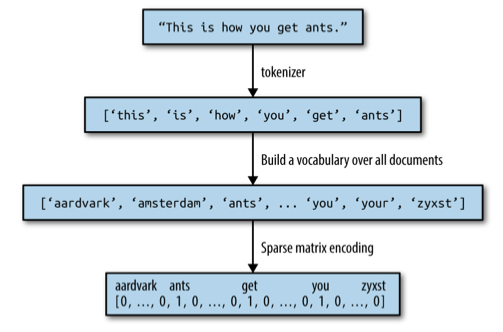

<div align="center">
    Process of BoW
</div>

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

You can use it as follows:

    1.Create an instance of the CountVectorizer class.
    2.Call the fit() function in order to learn a vocabulary from one or more documents.
    3.Call the transform() function on one or more documents as needed to encode each as a vector.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.<br>
<div style="text-align:right">— Jason Brownlee, How to Prepare Text Data for Machine Learning with scikit-learn, 2017.</div>

### 1.4.2 Tfidf Vectorizer

Tf-idf is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

- tf: term frequency in one document

- idf: inverse document frequency

In a **document**, the most frequent words tend to be more descripative of the document.

**But** words like "a", "the", "what" appear everywhere in all kinds of documents, they are not good keywords to distinguish documents.

Instead we are more interested in words that appear only in this specific document we are studying.

$$TFIDF(w,d) = tf\cdot log(\frac{N_d+1}{N_{d|w} + 1}) + 1$$
$N_d$: the number of documents in the training set

$N_{d|w}$: the number of documents in the training set that contains the word $w$

tf-idf is usually l2-normalized, i.e. the norm of the feature vector transformed from a document is 1.

Term Frequency (TF)

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.
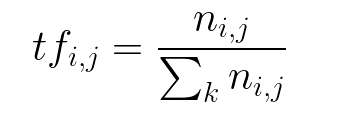

Inverse Data Frequency (IDF)

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.
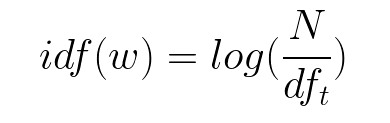<br>
<div style="text-align:right">— Cory Maklin, TF IDF | TFIDF Python Example, 2019.</div>

## 1.5 Grid Search & Cross Validation

In GridSearchCV, the training set is further splited into (k-1) <font color='red'>**training**</font> and 1 <font color='green'>**validating**</font> folds, where the <font color='green'>**validating**</font> set is supposed to simulate the <font color='blue'>**test**</font> set (unseen data).

Often, our fisrt step is to perform normalization (aka rescaling, e.g min_max) to the whole `X_train`.

Meaning that we have collected statistical infomation from the <font color='green'>**validating**</font> set before using it to validate our model.

This is clearly not the case for test set, we do not know anything (e.g. min, max) about the test set when learning a model, in other words, the <font color='green'>**validating**</font> set splitted from training set **after** such normalization fails to simulate completely unseen data:
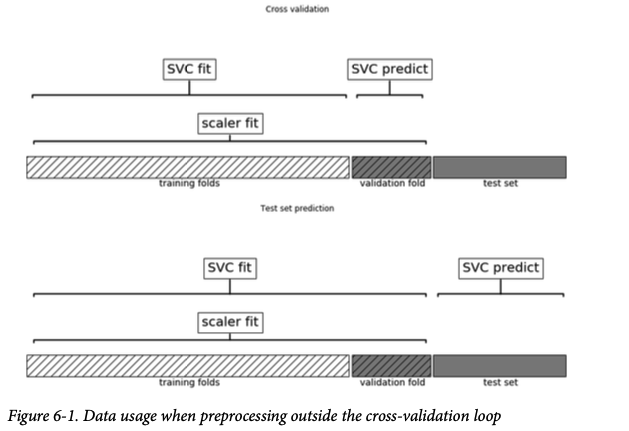

Idealy, each split in cross validation should apply normalization to the (k-1) <font color='red'>**training**</font> folds respectively, but leave out the 1 <font color='green'>**validating**</font> fold while doing so:
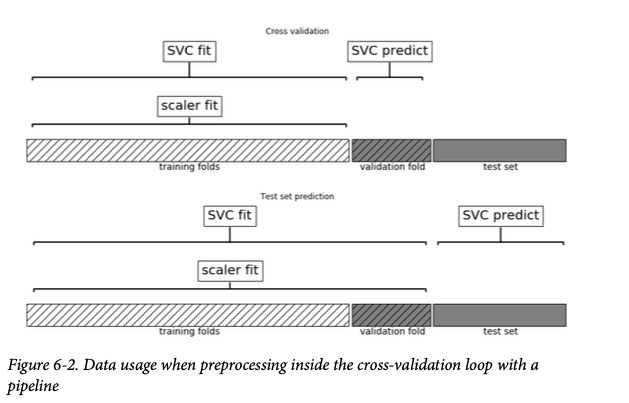

## 1.6 Functions Used In Models Construction

The following functions are functions that shared in different model constructions.

In [21]:
# Get scores for a particular model
def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
    
def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

# Show each topic's f1, accuracy and recall scores
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)
        
def namestr(obj):
    return [name for name in globals() if globals()[name] is obj][0]

# For an individual topic, get its f1, accuracy and recall scores        
def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
# Combine pipeline and GridSearchCV together
# Since grid search is time-consuming, the range of each elements in the parameter grid is 
# comparatively small
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
                "vectorizer__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)

# SMOTE the training data with vectorizer
def smote_data(df_train,vectorizer,col_x):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df[col_x].apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    return(new_train_x,smo_y,topics,le,encode_mapping)

# get a model that the training data is SMOTEd with vectorizer
def get_model(df_train,vectorizer,col_x):
    new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,vectorizer,col_x)
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)

# test the model's accuracy with dataframe named df_test      
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

## 1.7 Multinomial Naive Bayes Model

When Bayes' Rule is applied to documents and classes, we have:<br>
&emsp; (1)For a document *d* and a class *c* <br>
&emsp; $P(c|d)= \frac{P(d|c)P(c)}{P(d)}$ <br>
&emsp; $C_{MAP}=\underset{c\in C}{\operatorname{argmax}}P(x_{1},x_{2},...,x{n}|c)P(c)$ (MAP is "maximum a posterior" = most likely class)<br>
&emsp; $C_{NB}=\underset{c\in C}{\operatorname{argmax}}P(c_{j})\prod_{x \in X}P(X|c)$<br>
&emsp; (2)Maximum Likelihood Estimates <br>
&emsp;  $\hat{P}(c_{j})=\frac{doccount(C=c_{j})}{N_{doc}}$<br>
&emsp; $\hat{P}(w_{i}|c_{j})=\frac{count(w_{i},c_{j})}{\sum_{w \in V}count(w,c_{j})}$ &emsp;(fractions of times word $w_{i}$ appears among all words in documents of topic $c_{j}$).<br>
&emsp; (3)Laplace (add-1) Smoothing for Naive Bayes <br>
&emsp; $\hat{P}(w_{i}|c)=\frac{count(w_{i},c)+1}{\sum_{w \in V}(count(w,c))+1}=\frac{count(w_{i},c)+1}{\sum_{w \in V}count(w,c) + |V|}$

### 1.7.1 Two Layer Model Construction

We construct a two layer model. The first layer is predicting the target article belongs to **IRRELEVANT** topic or not. If the prediction is not **IRRELEVANT**, the target article goes to the second layer and gets predicted that in the rest of topics, which it belongs to. Considering a target article could be mistakenly predicted as not **IRRELEVANT** in the first layer, the second layer model should be still able to predict an article in **IRRELEVANT** topic.

#### 1.7.1.1 First Layer Construction

In [9]:
new_df = df_train
rel_topic = [] # relevance topic
for i in range(new_df.shape[0]):
    if(new_df.topic.iloc[i]=="IRRELEVANT"):
        rel_topic.append("IRRELEVANT")
    else:
        rel_topic.append("RELEVANT")
new_df['rel_topic']=rel_topic
rel_df_train= pd.DataFrame(df_train,columns=['article_words','rel_topic']).rename(columns={'rel_topic':'topic'})
rel_df_train.name = 'rel_df_train'

In [10]:
%%time
# training data is SMOTED with TfidfVectorizer
rel_clf_tfidf_NB,_,_= get_model(rel_df_train,TfidfVectorizer(),'article_words')

*************************************************************
Now the training set is rel_df_train, and the model chosen is count_clf_NB
The accuracy is 0.8369710788616329
CPU times: user 12.8 s, sys: 7.42 s, total: 20.2 s
Wall time: 6min 30s


In [21]:
%%time
# training data is SMOTED with CountVectorizer
rel_clf_count_NB,_,_= get_model(rel_df_train,CountVectorizer(),'article_words')

*************************************************************
Now the training set is rel_df_train, and the model chosen is count_clf_NB
The accuracy is 0.8360271326782245
CPU times: user 17.3 s, sys: 12.7 s, total: 30 s
Wall time: 8min 30s


Therefore, we choose the model whose training data is SMOTED with TfidfVectorier here.

In [22]:
save_variable(rel_clf_tfidf_NB,"rel_clf_tfidf_NB")

#### 1.7.1.2 Secod Layer Construction

When we train the model with training data, we want the model is trained with as much data as possible for guaranteeing the prediction accuracy. Therefore, we only train the model with full data and top 100 key words data.

##### 1.7.1.2.1 SMOTE With TfidfVectorizer

In [14]:
new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,TfidfVectorizer(),'article_words')
new_train_x_100,_,_,_,_ = smote_data(df_train,TfidfVectorizer(),'key_word_100')

In [15]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)

First we build the model with train_x first.

In [12]:
%%time
# Start grid search
count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x,train_y,topics)
tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x,train_y,topics)

CPU times: user 1min 17s, sys: 1min 10s, total: 2min 27s
Wall time: 1h 4min


In [13]:
clf_NB = None
if(count_clf_accuracy>=tfidf_clf_accuracy):
    print('count chosen')
    clf_NB = count_clf_NB
else:
    print('tfidf chosen')
    clf_NB = tfidf_clf_NB

tfidf chosen


In [15]:
# reverse valid_y
rev_valid_y = le.inverse_transform(valid_y)

----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6060058186436652
Accuracy score for  Pipeline  model is  0.6394478844169247
Recall score for  Pipeline  model is  0.642822930876334 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.48      0.60      1381
           1       0.75      0.30      0.43      1408
           2       0.73      0.85      0.78      1414
           3       0.62      0.97      0.76      1346
           4       0.57      0.30      0.39      1411
           5       0.65      0.77      0.70      1432
           6       0.17      0.05      0.08      1480
           7       0.46      

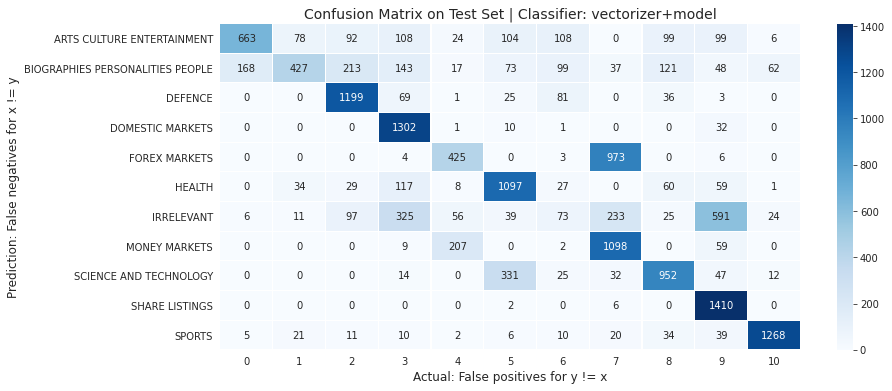

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.6690282734882739
Accuracy score for  Pipeline  model is  0.6926599587203303
Recall score for  Pipeline  model is  0.6960156377166793 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.51      0.64      1381
           1       0.72      0.50      0.59      1408
           2       0.79      0.91      0.84      1414
           3       0.75      0.99      0.86      1346
           4       0.64      0.32      0.42      1411
           5       0.70      0.88      0.78      1432
           6       0.18      0.08      0.11      1480
           7       0.46     

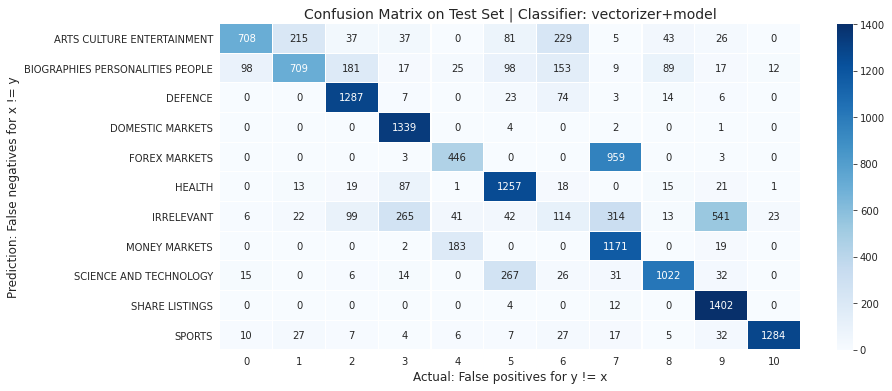

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7090315321806421
Accuracy score for  Pipeline  model is  0.7297471620227038
Recall score for  Pipeline  model is  0.7330162220650392 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1381
           1       0.79      0.58      0.67      1408
           2       0.73      0.94      0.82      1414
           3       0.83      0.99      0.90      1346
           4       0.65      0.30      0.41      1411
           5       0.79      0.94      0.86      1432
           6       0.26      0.12      0.16      1480
           7       0.47     

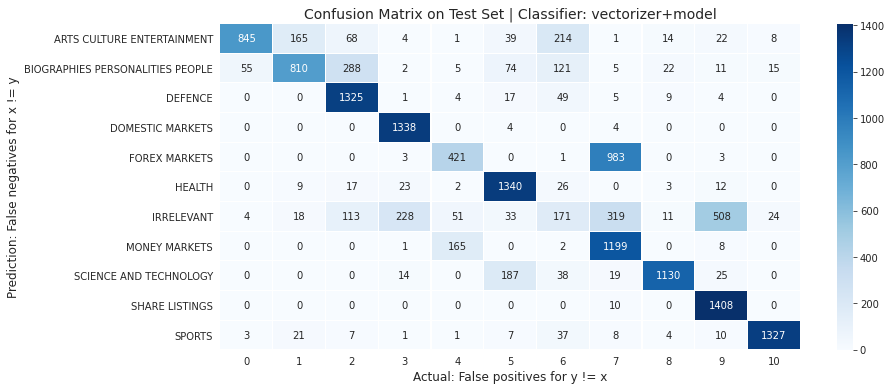

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.768182732198574
Accuracy score for  Pipeline  model is  0.7816692466460269
Recall score for  Pipeline  model is  0.7847917024466192 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1381
           1       0.85      0.74      0.79      1408
           2       0.81      0.93      0.86      1414
           3       0.87      1.00      0.93      1346
           4       0.69      0.34      0.45      1411
           5       0.85      0.94      0.89      1432
           6       0.45      0.22      0.30      1480
           7       0.49     

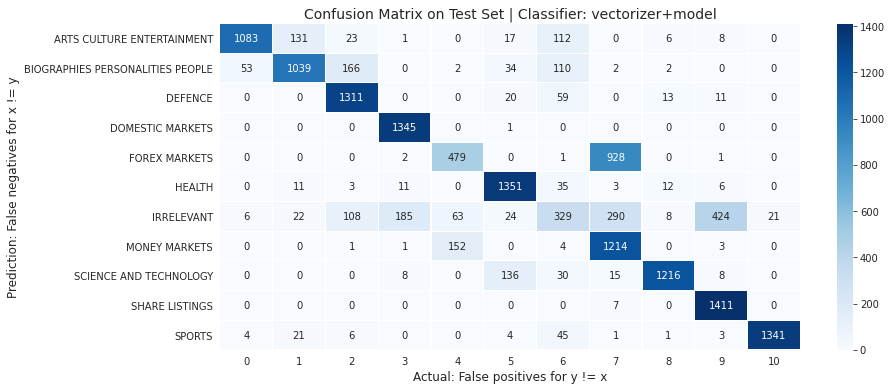

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.9614464063257244
Accuracy score for  Pipeline  model is  0.9612358101135191
Recall score for  Pipeline  model is  0.9618060278223646 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1381
           1       0.99      1.00      1.00      1408
           2       0.99      1.00      1.00      1414
           3       0.99      1.00      1.00      1346
           4       0.90      0.81      0.85      1411
           5       1.00      1.00      1.00      1432
           6       0.99      0.84      0.91      1480
           7       0.77      0.

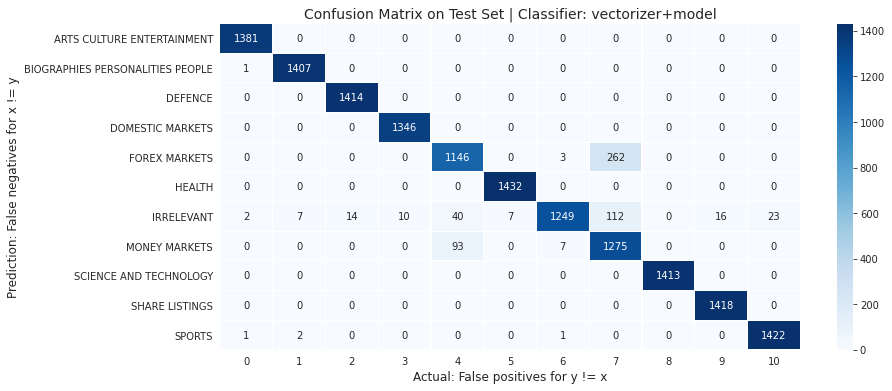

In [16]:
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB,le,encode_mapping)

Now, we train the model with train_x_100.

In [17]:
%%time
# Start grid search
count_clf_NB_100,count_clf_100_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x_100,train_y,topics)
tfidf_clf_NB_100,tfidf_clf_100_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x_100,train_y,topics)

CPU times: user 46.6 s, sys: 5.17 s, total: 51.7 s
Wall time: 21min 52s


tfidf chosen
----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6864399599467194
Accuracy score for  Pipeline  model is  0.7054308565531475
Recall score for  Pipeline  model is  0.7079436010041952 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68      1381
           1       0.67      0.49      0.57      1408
           2       0.79      0.89      0.84      1414
           3       0.75      0.95      0.84      1346
           4       0.62      0.73      0.67      1411
           5       0.67      0.84      0.74      1432
           6       0.32      0.13      0.18      1480
           7   

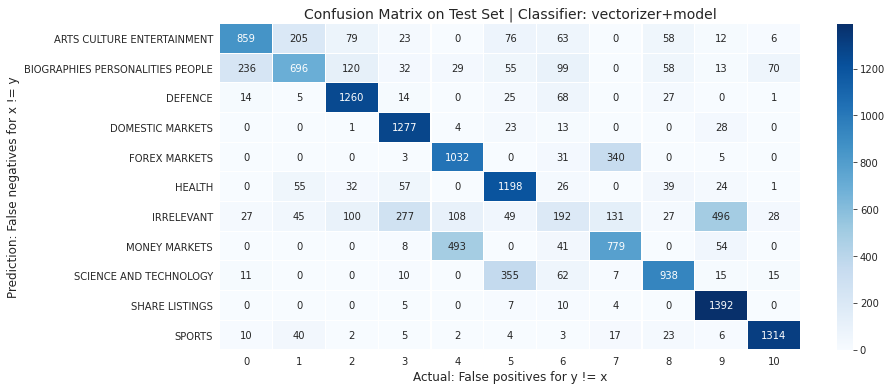

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.7408080995788019
Accuracy score for  Pipeline  model is  0.7530959752321982
Recall score for  Pipeline  model is  0.7553985045818248 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1381
           1       0.70      0.68      0.69      1408
           2       0.83      0.94      0.88      1414
           3       0.82      0.95      0.88      1346
           4       0.65      0.70      0.67      1411
           5       0.71      0.91      0.79      1432
           6       0.45      0.21      0.29      1480
           7       0.61     

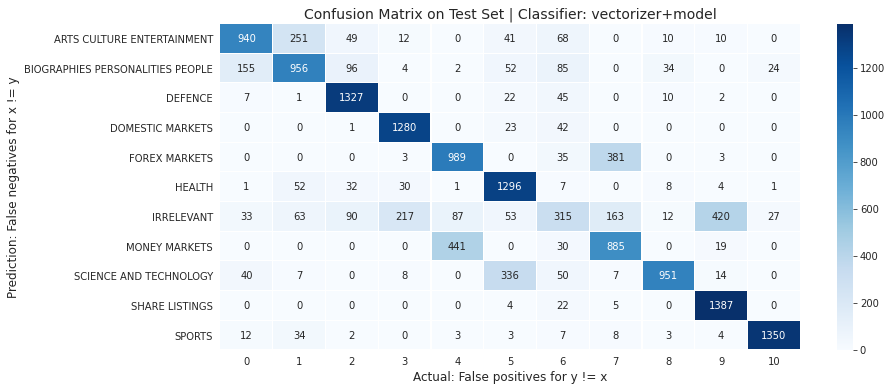

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7987624424198337
Accuracy score for  Pipeline  model is  0.8071465428276574
Recall score for  Pipeline  model is  0.80922575870362 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1381
           1       0.78      0.80      0.79      1408
           2       0.84      0.96      0.90      1414
           3       0.87      0.97      0.91      1346
           4       0.64      0.72      0.68      1411
           5       0.79      0.93      0.85      1432
           6       0.65      0.32      0.43      1480
           7       0.64      0

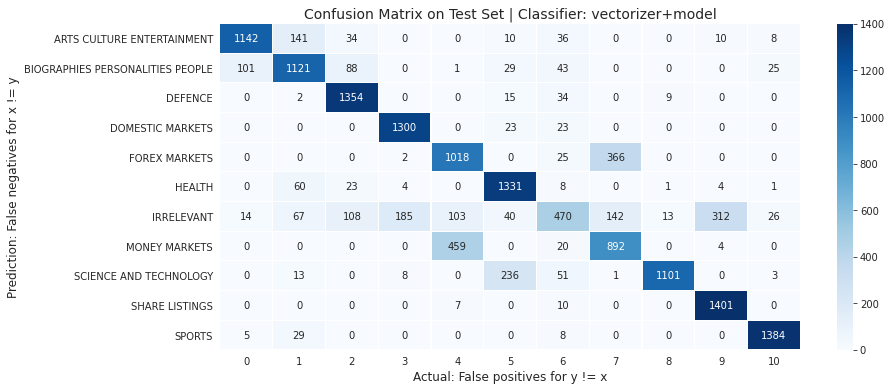

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.832104107646368
Accuracy score for  Pipeline  model is  0.8360423116615067
Recall score for  Pipeline  model is  0.8377748099659977 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1381
           1       0.84      0.87      0.85      1408
           2       0.89      0.95      0.92      1414
           3       0.90      0.99      0.94      1346
           4       0.64      0.66      0.65      1411
           5       0.83      0.96      0.89      1432
           6       0.73      0.46      0.56      1480
           7       0.61     

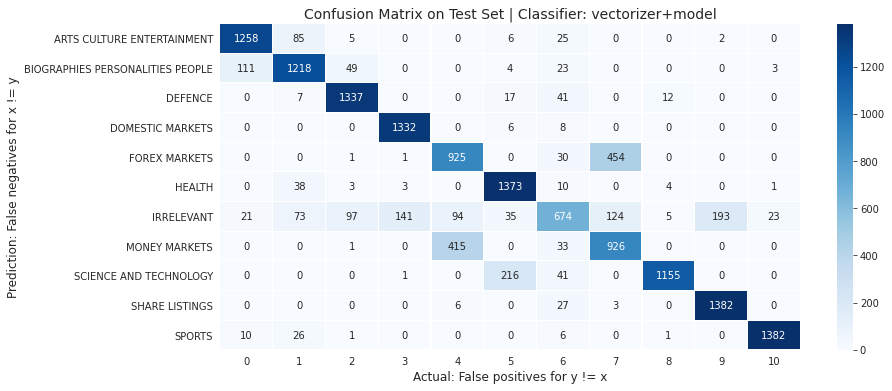

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.833076656396831
Accuracy score for  Pipeline  model is  0.8369453044375645
Recall score for  Pipeline  model is  0.83869077560183 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1381
           1       0.83      0.87      0.85      1408
           2       0.91      0.96      0.93      1414
           3       0.90      0.99      0.94      1346
           4       0.64      0.66      0.65      1411
           5       0.84      0.95      0.89      1432
           6       0.74      0.46      0.56      1480
           7       0.62      0.67 

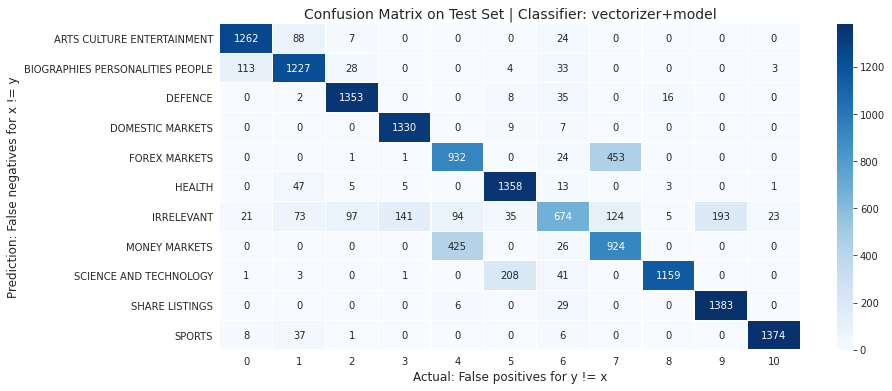

In [18]:
clf_NB_100 = None
if(count_clf_100_accuracy>=tfidf_clf_100_accuracy):
    print('count chosen')
    clf_NB_100 = count_clf_NB_100
else:
    print('tfidf chosen')
    clf_NB_100 = tfidf_clf_NB_100
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB_100,le,encode_mapping)

##### 1.7.1.2.2 SMOTE With CountVectorizer

In [22]:
new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,CountVectorizer(),'article_words')
new_train_x_100,_,_,_,_ = smote_data(df_train,CountVectorizer(),'key_word_100')

In [23]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)

First we build the model with train_x first.

In [21]:
%%time
# Start grid search
count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x,train_y,topics)
tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x,train_y,topics)

CPU times: user 37.5 s, sys: 3.34 s, total: 40.8 s
Wall time: 15min 56s


In [22]:
clf_NB = None
if(count_clf_accuracy>=tfidf_clf_accuracy):
    print('count chosen')
    clf_NB = count_clf_NB
else:
    print('tfidf chosen')
    clf_NB = tfidf_clf_NB

tfidf chosen


----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6182848214081008
Accuracy score for  Pipeline  model is  0.6611197110423117
Recall score for  Pipeline  model is  0.6635177618675048 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      1381
           1       0.61      0.50      0.55      1408
           2       0.66      0.88      0.75      1414
           3       0.54      0.97      0.69      1346
           4       0.55      0.95      0.70      1411
           5       0.69      0.72      0.71      1432
           6       0.91      0.01      0.01      1480
           7       0.79     

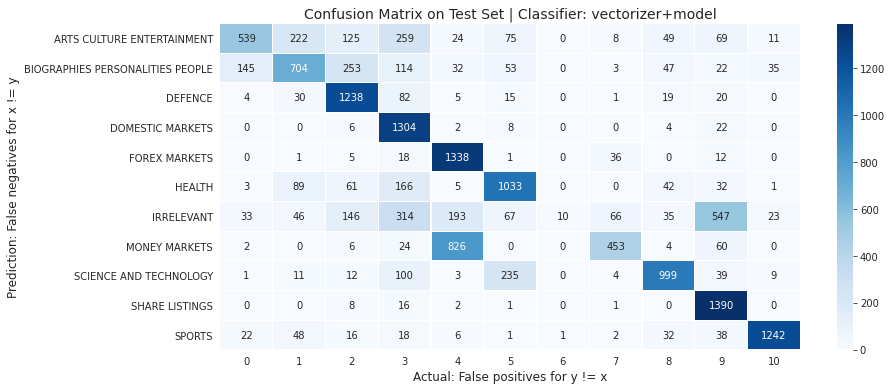

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.6711941130314357
Accuracy score for  Pipeline  model is  0.7078173374613003
Recall score for  Pipeline  model is  0.7105199584304711 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.52      0.60      1381
           1       0.67      0.59      0.63      1408
           2       0.74      0.91      0.81      1414
           3       0.66      0.99      0.79      1346
           4       0.54      0.94      0.69      1411
           5       0.74      0.80      0.77      1432
           6       0.83      0.02      0.04      1480
           7       0.74     

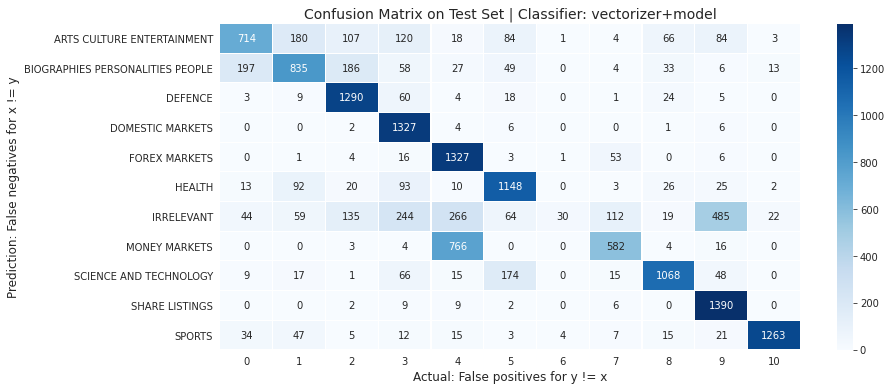

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7308612343385583
Accuracy score for  Pipeline  model is  0.7582559339525283
Recall score for  Pipeline  model is  0.7610655822537894 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1381
           1       0.75      0.72      0.73      1408
           2       0.74      0.92      0.82      1414
           3       0.79      0.99      0.88      1346
           4       0.56      0.90      0.69      1411
           5       0.79      0.85      0.82      1432
           6       0.88      0.07      0.13      1480
           7       0.66     

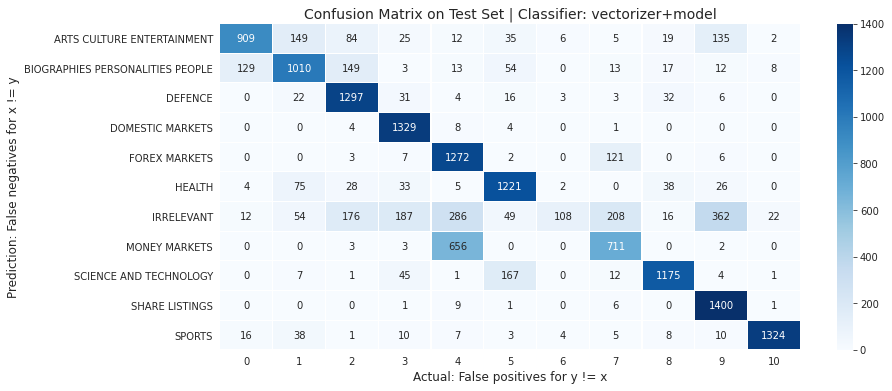

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.7859317370418019
Accuracy score for  Pipeline  model is  0.7997291021671826
Recall score for  Pipeline  model is  0.8019479008067528 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      1381
           1       0.80      0.79      0.79      1408
           2       0.81      0.93      0.87      1414
           3       0.84      0.98      0.91      1346
           4       0.58      0.87      0.70      1411
           5       0.85      0.87      0.86      1432
           6       0.87      0.24      0.37      1480
           7       0.64    

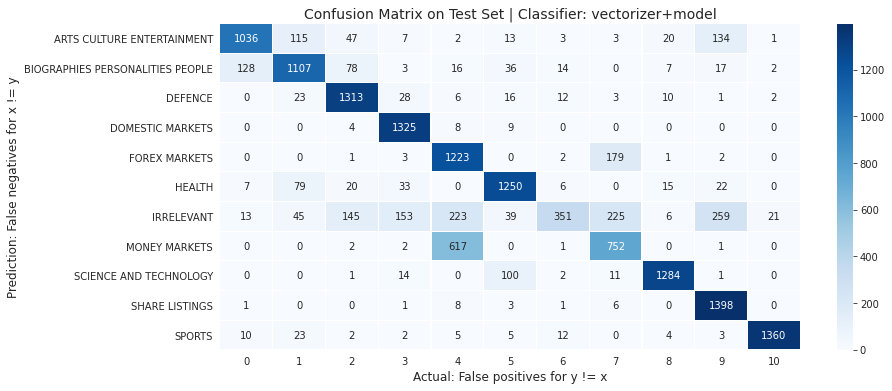

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.9303539042327637
Accuracy score for  Pipeline  model is  0.9300825593395253
Recall score for  Pipeline  model is  0.930055853282677 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1381
           1       0.99      0.98      0.98      1408
           2       0.99      0.97      0.98      1414
           3       0.99      0.98      0.99      1346
           4       0.73      0.86      0.79      1411
           5       0.99      0.98      0.99      1432
           6       0.83      0.84      0.84      1480
           7       0.77      0.6

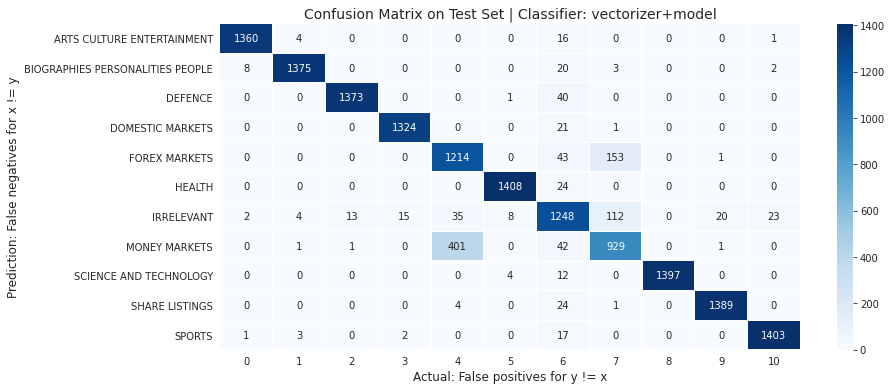

In [23]:
# reverse valid_y
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB,le,encode_mapping)

In [24]:
%%time
# Start grid search
count_clf_NB_100,count_clf_100_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x_100,train_y,topics)
tfidf_clf_NB_100,tfidf_clf_100_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x_100,train_y,topics)

CPU times: user 26.8 s, sys: 2.04 s, total: 28.9 s
Wall time: 10min 10s


count chosen
----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6711901000023661
Accuracy score for  Pipeline  model is  0.6928246815592396
Recall score for  Pipeline  model is  0.6923134261638659 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1412
           1       0.54      0.62      0.58      1416
           2       0.82      0.88      0.85      1371
           3       0.77      0.92      0.84      1407
           4       0.61      0.92      0.73      1480
           5       0.64      0.79      0.71      1446
           6       0.22      0.10      0.13      1418
           7   

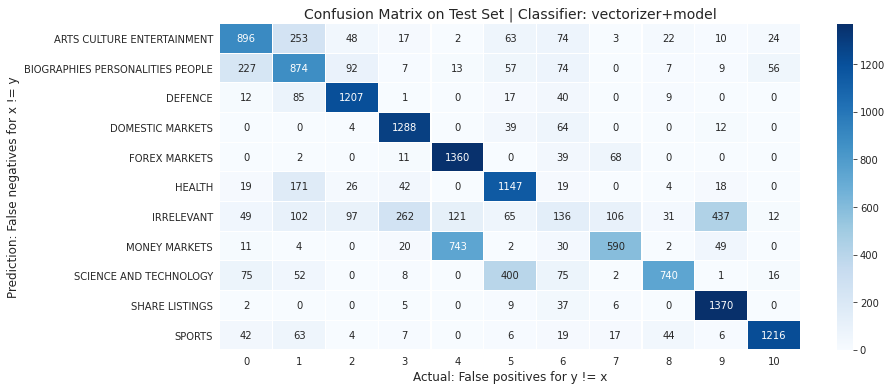

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.7176578483425889
Accuracy score for  Pipeline  model is  0.724316712539205
Recall score for  Pipeline  model is  0.7237874760333548 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1412
           1       0.67      0.73      0.70      1416
           2       0.86      0.90      0.88      1371
           3       0.85      0.83      0.84      1407
           4       0.61      0.82      0.70      1480
           5       0.66      0.90      0.76      1446
           6       0.31      0.25      0.27      1418
           7       0.68      

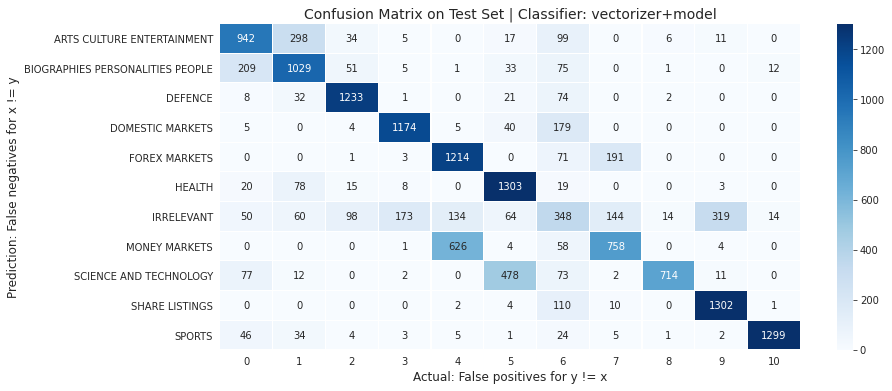

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7201098888152814
Accuracy score for  Pipeline  model is  0.7091467707866607
Recall score for  Pipeline  model is  0.7090504508369878 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.57      0.69      1412
           1       0.67      0.81      0.73      1416
           2       0.85      0.91      0.88      1371
           3       0.91      0.64      0.75      1407
           4       0.62      0.66      0.64      1480
           5       0.70      0.85      0.77      1446
           6       0.29      0.51      0.37      1418
           7       0.65     

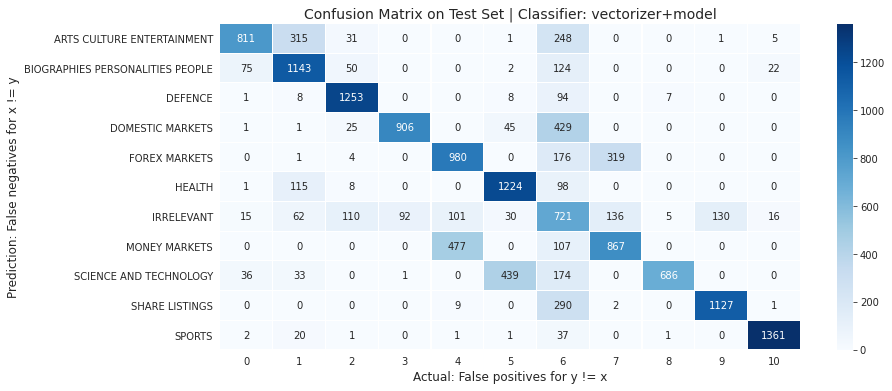

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.8356639865954901
Accuracy score for  Pipeline  model is  0.8348588619343276
Recall score for  Pipeline  model is  0.8358824144433243 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1412
           1       0.80      0.84      0.82      1416
           2       0.88      0.91      0.90      1371
           3       0.93      0.96      0.95      1407
           4       0.66      0.74      0.70      1480
           5       0.85      0.87      0.86      1446
           6       0.71      0.67      0.69      1418
           7       0.67    

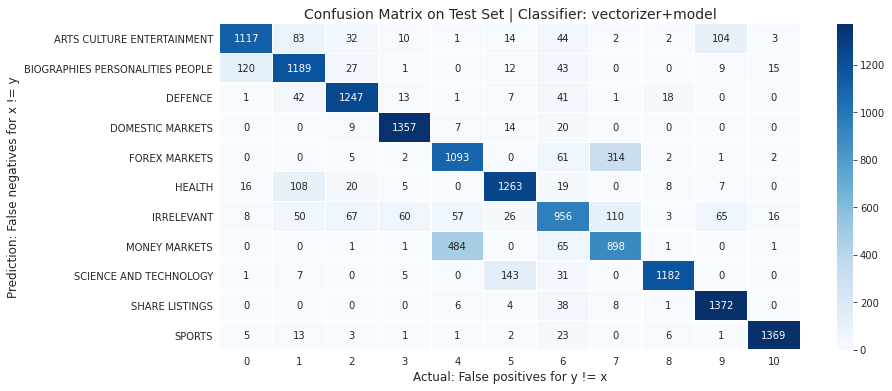

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.8383882584544057
Accuracy score for  Pipeline  model is  0.8373551814632273
Recall score for  Pipeline  model is  0.8383183219212792 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1412
           1       0.80      0.86      0.83      1416
           2       0.89      0.91      0.90      1371
           3       0.94      0.96      0.95      1407
           4       0.67      0.74      0.70      1480
           5       0.82      0.86      0.84      1446
           6       0.72      0.67      0.69      1418
           7       0.67      0.

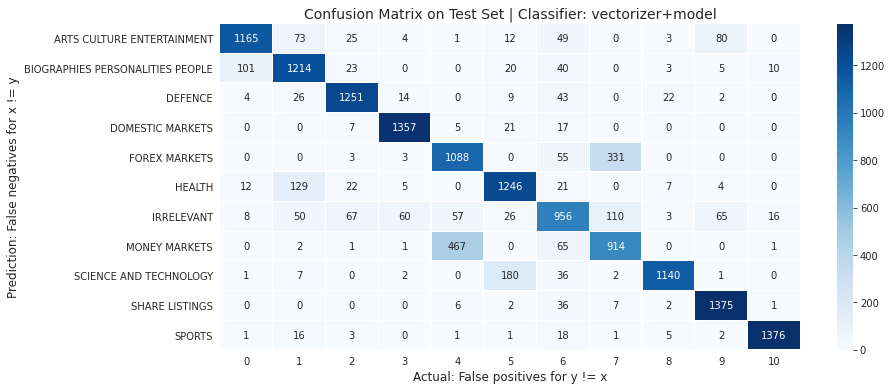

In [25]:
clf_NB_100 = None
if(count_clf_100_accuracy>=tfidf_clf_100_accuracy):
    print('count chosen')
    clf_NB_100 = count_clf_NB_100
else:
    print('tfidf chosen')
    clf_NB_100 = tfidf_clf_NB_100
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB_100,le,encode_mapping)

## 1.8 Logistic Regression Model

In Logistic Regression Model, we find out the best estimator parameters *W* by calculating the **maximum likelihood estimator**. The likelihood function is given as:<br>
<div align='middle'>$\begin{align*}L(W)&=\sum_{i=1}^{n}lnp(y_{i}|X_{i},W)\\
&=\sum_{i=1}^{n}ln(\phi (z_{i})^{y_{i}}(1-\phi (z_{i}))^{1-y_{i}})\\
&=\sum_{i=1}^{n}ln\phi (z_{i})+(1-y_{i})ln(1-\phi (z_{i}))
\end{align*}$</div> <br>
By calculating the derivative of likelihood function, we can get the loss function:<br>
<div align='middle'>
    $J(W)=-\sum_{i=1}^{n}y_{i}ln\phi (z_{i})+(1-y_{i})ln(1-\phi (z_{i}))$
</div><br>

# 2 Ensemble Model Construction

From the results above, it could be seen that no models above are able to predict every topic 100% correctly. However, a glance at the results indicates that different types of model have their strong prediction among different topics. Hence, an idea comes to mind that if we construct an ensemble model to integrate all precise prediction from different models,the final prediction quality could be tremendously enhanced.

<font color='blue'>Ensemble methods</font> are mega-algorithms that <font color='blue'>combine different models</font> into one model and they can:<br>
- Decrease variance
- Decrease bias
- Improve performance
- Aggregation of information in groups (by James Surowiecki, 1907)
<div style="text-align:right">— Week 7 Lecture Slides Part1, 2020.</div>

There are five simple ensemble methods introduced in this course: <br>
&emsp;    1.Majority vote for models' outputs.<br>
&emsp;    2.Weighted averages/votes.<br>
&emsp;    3.Treat the output of each model as a feature and train a model on that.<br>
&emsp;    4.Mixture of experts.<br>
&emsp;    5."Bagging" method.

Considering that in this group project, only an imbalanced training data set and a test set are provided, using "Bagging" method is not practical since we cannot tune the "Bagging" method outputs with a validation data set, and the original size of training data set is merely 9500 lines, which is assumed to be small for "bagging" process. Moreover, among the models: Multinomial Naive Bayes, Support Vector Machine, Logistic Regression, and Decision Tree Classifier, there is no prior knowledge that how much expertise they have on the training data set correspondingly. Thus, we choose the first method for the sakes of easy operation.